# Hands On - Aprendizado Federado aplicado à Internet das Coisas

**Notebook 1**: Introdução a reconhecimento de atividades humanas

Nesse tutorial, vamos aprender como treinar uma rede neural para auxilar no reconhecimento de atividades humanas (*Human Activity Recognition* - HAR) usando redes neurais convolucionais e o framework Pytorch.
Nosso objetivo aqui é demonstrar os benefícios do uso de redes neurais para modelar problemas de IoT quando se tem pouco ou nenhum conhecimento de domínio. 

### Dataset

Possuimos cerca de 20.000 leituras de sensores de 6 participantes realizando 5 ações diferentes. 
Cada leitura consiste em:

- medições de pose (roll, pitch, yaw), 
- acelerômetro (medições de aceleração linear), 
- giroscópio (medições da velocidade de rotação).

Cada feature é representada por um vetor 3D apontando na direção da leitura em um determinado passo de tempo para quatro sensores diferentes (cinto, braço, antebraço, haltere). 

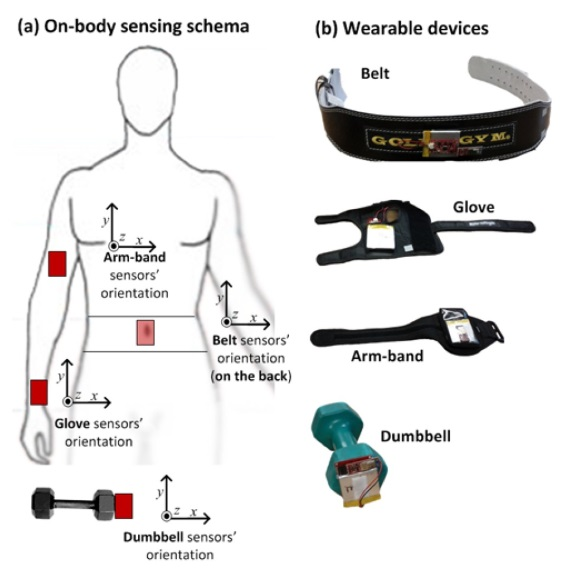


Os participantes foram convidados a realizar uma série de 10 repetições da rosca direta com halteres unilaterais de cinco maneiras diferentes:

1.   Atendendo precisamente às especificações (Classe A)
2.   Jogando os cotovelos para a frente (Classe B)
3.   Levantando os halteres apenas pela metade (Classe C)
4.   Abaixando os halteres apenas pela metade (Classe D)
5.   Lançar o quadril para a frente (Classe E).


Cada leitura foi normalizada em relação às amostras na mesma categoria no conjunto de dados e concatenadas em um único intervalo de tempo, formando assim um vetor de features de dimensão 40 x 1.

Para avaliação dos resultados do nosso modelo, usamos uma taxa de divisão de 0,33 para dados de treinamento e validação (66% de treinamento, 33% de validação).

In [6]:
# Particionamento do dataset
import torch
import pandas as pd
import numpy as np
import aux_centralized

DATA_ROOT = "./data/pml-training.csv"

server_address = "[::]:8081"
cid = 0
nb_clients = 1
train_batch_size = 64
test_batch_size = 64
epochs = 100

dataset = aux_centralized.HARdataset(DATA_ROOT)

train_sampler, test_sampler = dataset.split_ind(val_split = 0.33,
                                                shuffle = True)

train_loader =  torch.utils.data.DataLoader(dataset, 
                                            batch_size = 64, 
                                            shuffle = False,  
                                            sampler = train_sampler)

test_loader =  torch.utils.data.DataLoader(dataset, 
                                           batch_size = 64, 
                                           shuffle = False,  
                                           sampler = test_sampler)



### Metodologia 

Abaixo podemos observar como funciona um fluxograma para o reconhecimento de atividades humanas:

1. Os dados brutos são primeiramente adquiridos de sensores, 
2. Aplicamos o pré-processamento,
3. Segmentos de dados são então extraídos (segmentação),
4. Os valores relevantes para o problema de reconhecimento são calculados a partir dos segmentos (extração de recursos), 
3. Um classificador é então treinado e avaliado usando esses recursos (Classificação). 


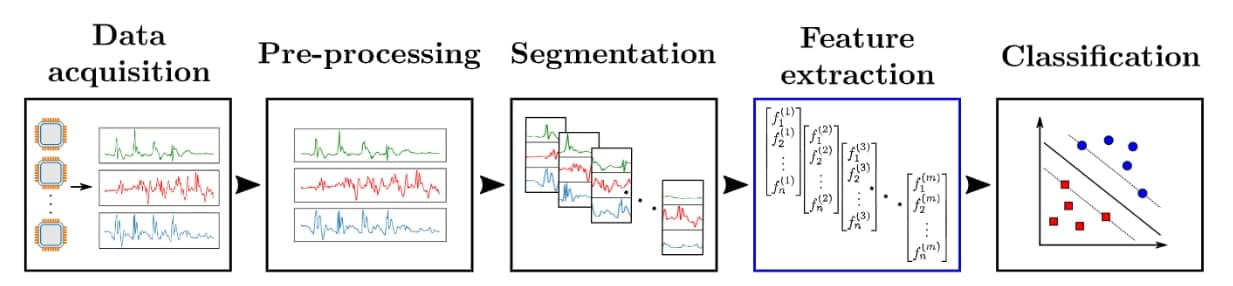



Nos dados utilizados, todas as etapas acima - exceto a parte de extração de recursos e classificação - já foram previamente realizadas.

### Redes Neurais

Nos últimos anos, redes neurais convolucionais, que ganharam reconhecimento por seu desempenho em tarefas relacionadas à visão computacional, também encontraram aplicações em modelagem de sequências unidimensionais, como HAR.

Em nossa implementação, usaremos uma CNN 1D simples com 3 camadas conv e 2 camadas totalmente conectadas.
Cada camada é seguida por uma função de ativação ReLU e uma camada de exclusão. 
Nossa taxa de aprendizado inicial é 0,003, com uma taxa de decaimento de 0,95 por época. 
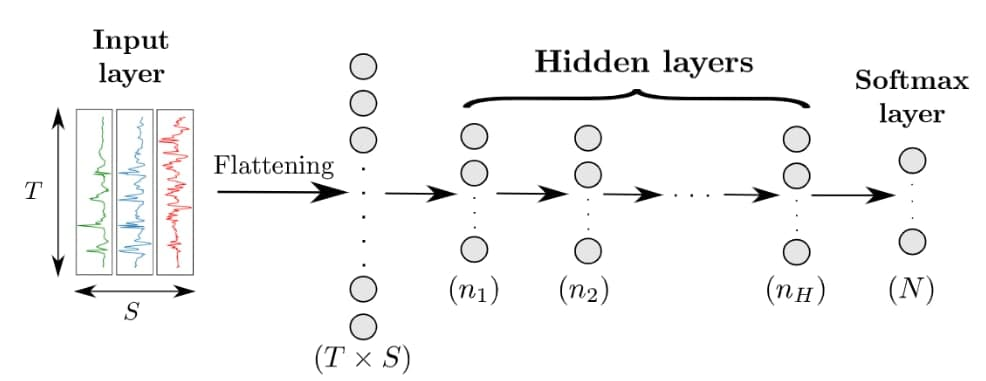


In [7]:
import torch.nn as nn
import torch

class HARmodel(nn.Module):
    """Model for human-activity-recognition."""
    def __init__(self, input_size, num_classes):
        super().__init__()

        # Extract features, 1D conv layers
        self.features = nn.Sequential(
            nn.Conv1d(input_size, 64, 1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(64, 64, 1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(64, 64, 1),
            nn.ReLU(),
            nn.Flatten(),
            )
        # Classify output, fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        out = self.classifier(x)

        return out

### Treinando o modelo

In [8]:
def train(model, train_loader, epochs, device: torch.device = torch.device("cpu")):
    
    model.train()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr = 0.003,
                                momentum = 0.9,
                                weight_decay = 1e-4)
    
    print(f"Training {epochs} epoch(s) w/ {len(train_loader)} mini-batches each")
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        loss_epoch: float = 0.0
        num_examples_train: int = 0
        correct: int = 0
            
        for batch_idx, (data, target, _) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            num_examples_train += len(data)

            output = model(data.permute(0, 2, 1))
            loss = torch.nn.CrossEntropyLoss()(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss_epoch += loss.item()
            
        if epoch % 10 == 1 :
                print()
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} ACC: {:.6f}\t\t\t\t".format(
                        epoch,
                        num_examples_train,
                        len(train_loader) * train_loader.batch_size,
                        100.0
                        * num_examples_train
                        / len(train_loader)
                        / train_loader.batch_size,
                        loss.item(),  correct/num_examples_train
                    ),
                    end = "\n",
                    flush = True,
                )
    return correct/num_examples_train


In [9]:
from torch import Tensor, optim

device = torch.device("cpu")
model = HARmodel(40, 5).to(device)

train(model, train_loader, epochs, device)

Training 100 epoch(s) w/ 206 mini-batches each

Train Epoch: 1 [13147/13184 (100%)] Loss: 1.580127 ACC: 0.286301				

Train Epoch: 11 [13147/13184 (100%)] Loss: 1.408527 ACC: 0.409675				

Train Epoch: 21 [13147/13184 (100%)] Loss: 1.161268 ACC: 0.540047				

Train Epoch: 31 [13147/13184 (100%)] Loss: 0.860597 ACC: 0.639233				

Train Epoch: 41 [13147/13184 (100%)] Loss: 0.601902 ACC: 0.688902				

Train Epoch: 51 [13147/13184 (100%)] Loss: 0.902063 ACC: 0.725337				

Train Epoch: 61 [13147/13184 (100%)] Loss: 0.570239 ACC: 0.744504				

Train Epoch: 71 [13147/13184 (100%)] Loss: 0.524825 ACC: 0.764205				

Train Epoch: 81 [13147/13184 (100%)] Loss: 0.633445 ACC: 0.777212				

Train Epoch: 91 [13147/13184 (100%)] Loss: 0.482896 ACC: 0.790370				


0.7953145204229102

### Testando o modelo

In [10]:
import torch.nn.functional as F

def test(model, test_loader, device: torch.device = torch.device("cpu")) :
    
    model.eval()
    
    test_loss: float = 0
    correct: int = 0
    num_test_samples: int = 0
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target, _ in test_loader:
            data, target = data.to(device), target.to(device)
            num_test_samples += len(data)
            output = model(data.permute(0, 2, 1))
            test_loss += criterion(output, target)
            pred = output.argmax(dim = 1, keepdim = True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= num_test_samples

    return (num_test_samples, test_loss, correct/num_test_samples )

In [11]:
num_samples, loss, acc = test(model, test_loader, device)
print(f"Evaluation (#{num_samples} samples) : Loss {loss.item()} Acc {acc}")

Evaluation (#6475 samples) : Loss 0.006058879662305117 Acc 0.8863320463320463


### Referências

https://github.com/jchiang2/Human-Activity-Recognition

M. Zeng et al., "Convolutional Neural Networks for human activity recognition using mobile sensors," 6th International Conference on Mobile Computing, Applications and Services, Austin, TX, 2014, pp. 197-205.

F. Li, K. Shirahama, M.A. Nisar, L. Köping, M. Grzegorzek, "Comparison of feature learning methods for human activity recognition using wearable sensors," Sensors 2018, 18, 679.

Velloso, E.; Bulling, A.; Gellersen, H.; Ugulino, W.; Fuks, H. Qualitative Activity Recognition of Weight Lifting Exercises. Proceedings of 4th International Conference in Cooperation with SIGCHI (Augmented Human ’13) . Stuttgart, Germany: ACM SIGCHI, 2013.